# Diet Classification - Part 3

Part 3 consist of the preprocessing and modelling of the combined datasets. Data extraction and EDA will be available in Part 1 and Part 2 respectively.

## Content

- [Data Import](#Data-Import)
- [Preprocessing and Modelling](#Preprocessing-and-Modelling)
- [Cross-Over Review and Evaluation](#Crossover-Review-and-Evaluation)
- [Conclusion and Recommendation](#Conclusion-&-Recommendation)

## Data Import

In [1]:
#import vanilla python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import preprocessing library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
#Import combine datasets for cleaning
combined = pd.read_csv('../data/combined_df')
#set max row preview
pd.set_option('display.max_column', 1000)

In [3]:
combined.head()

,author,link_flair_text,num_comments,subreddit_subscribers,subreddit,text,post_datetime,date,hour,day,text_word_count
0,Elise_93,Funny,0,590954,vegan,A summary of carnist logic about PETA:,2021-04-18 02:03:10,2021-04-18,2,18,7
1,SeviathanVonEldritch,Rant,0,590952,vegan,Underestimated it as well...,2021-04-18 01:57:56,2021-04-18,1,18,4
2,quidiuris,Uncategorised,0,590952,vegan,Hair conditioner bars - any recommendations?,2021-04-18 01:55:05,2021-04-18,1,18,6
3,lunanabiki,Uncategorised,0,590953,vegan,nonvegan logic that surprises me (that i haven...,2021-04-18 01:51:11,2021-04-18,1,18,12
4,pastelprincess1,Uncategorised,0,590953,vegan,Sustainable + Ethical Alternatives Directory,2021-04-18 01:50:06,2021-04-18,1,18,5


In [4]:
#checking to ensure no null value
combined.isna().sum()

author                   0
link_flair_text          0
num_comments             0
subreddit_subscribers    0
subreddit                0
text                     0
post_datetime            0
date                     0
hour                     0
day                      0
text_word_count          0
dtype: int64

## Preprocessing and Modelling

In the preprocessing, we will start with dissecting the text table to remove special characters, like emojis, and digits which will not be critical to the this context. The words will also be filtered on the stop words before modelling.

### Removing special characters and text processing

In [13]:
#import tokenization library
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re

In [14]:
#define tokenizer
def clean_text(words):
    """input for words/text in string to remove special characters"""
    #lowercase words
    words = words.lower()
    
    #remove other words/digit/special character
    tokenizer = RegexpTokenizer(r'[a-z]+')
    words = tokenizer.tokenize(words)
    
    #stem/lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    #remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [19]:
#apply function to clean text
cleaned_text  = combined['text'].apply(clean_text)

In [20]:
#add col for cleaned text
combined['cleaned_text'] = cleaned_text

In [21]:
#checking sanity of data
combined.isnull().sum()

author                   0
link_flair_text          0
num_comments             0
subreddit_subscribers    0
subreddit                0
text                     0
post_datetime            0
date                     0
hour                     0
day                      0
text_word_count          0
cleaned_text             0
dtype: int64

In [29]:
#drop empty cleaned_text
combined = combined[combined.cleaned_text != '']

### Modelling

Naives Bayes and Logistic Regression model will be employed for this classification model. These results will be processed through CountVectoriser and TfidfVectoriser to observed the best model pairing of prediction. The best model will then be used for final prediction. The models will be evaluated based on accuracy score. In this problem statement, we are looking for text keywords that may lead us to derive a better understanding on the keto-redditers to market vegan products better.

### Baseline Model

In [31]:
combined.head()

,author,link_flair_text,num_comments,subreddit_subscribers,subreddit,text,post_datetime,date,hour,day,text_word_count,cleaned_text
0,Elise_93,Funny,0,590954,vegan,A summary of carnist logic about PETA:,2021-04-18 02:03:10,2021-04-18,2,18,7,summari carnist logic peta
1,SeviathanVonEldritch,Rant,0,590952,vegan,Underestimated it as well...,2021-04-18 01:57:56,2021-04-18,1,18,4,underestim well
2,quidiuris,Uncategorised,0,590952,vegan,Hair conditioner bars - any recommendations?,2021-04-18 01:55:05,2021-04-18,1,18,6,hair condition bar ani recommend
3,lunanabiki,Uncategorised,0,590953,vegan,nonvegan logic that surprises me (that i haven...,2021-04-18 01:51:11,2021-04-18,1,18,12,nonvegan logic surpris seen yet
4,pastelprincess1,Uncategorised,0,590953,vegan,Sustainable + Ethical Alternatives Directory,2021-04-18 01:50:06,2021-04-18,1,18,5,sustain ethic altern directori


In [32]:
#define feature and target 

X = combined['cleaned_text']
y = combined['subreddit']

In [33]:
#check proportion of both reddits
y.value_counts(normalize = True)

keto     0.50893
vegan    0.49107
Name: subreddit, dtype: float64

In [34]:
baseline = round(y.value_counts(normalize = True),3).values.max()
print(f'Baseline Accuracy: {baseline}')

Baseline Accuracy: 0.509


The datasets in general are considered balance dataset. 
The above is the baseline model of accuracy 0.508 and our model is expected to outperform this score. 

In [35]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size= 0.33, 
                                                    random_state=42)

### Logistic Regression

#### Count Vectorization

In [36]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'cvec__max_features': [8000, 8500],
    'cvec__max_df': [0.8, 0.85],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_cvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.971830985915493
Testing Accuracy:  0.9366720516962843




{'cvec__max_df': 0.8,
 'cvec__max_features': 8500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'lr__C': 1,
 'lr__penalty': 'l2'}

#### Tfidf Vectorization

In [37]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'tvec__max_features': [8000, 8500],
    'tvec__max_df': [0.7, 0.8],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_tvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.959337948595528
Testing Accuracy:  0.9408723747980614




{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.7,
 'tvec__max_features': 8000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

### Naive Bayes

#### Count Vectorization

In [38]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [8000, 9000],
    'cvec__max_df': [0.3, 0.4],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_cvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9337948595527971
Testing Accuracy:  0.9187399030694668




{'cvec__max_df': 0.4,
 'cvec__max_features': 8000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'nb__alpha': 0.6326530612244897}

#### Tfidf Vectorization

In [39]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [8000, 8500],
    'tvec__max_df': [0.4, 0.5],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_tvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9325216837749661
Testing Accuracy:  0.9159935379644588




{'nb__alpha': 1.0,
 'tvec__max_df': 0.4,
 'tvec__max_features': 8500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [40]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Baseline','Logistic Regression','Logistic Regression','Naives Bayes','Naives Bayes'],
    'Vectorizer' :['','CountVectorizer','TfidfVectorizer','CountVectorizer','TfidfVectorizer'],
    'Training Accuracy' : [baseline, best_lr_cvec.score(X_train, y_train), best_lr_tvec.score(X_train, y_train), 
                           best_nb_cvec.score(X_train, y_train), best_nb_tvec.score(X_train, y_train)],
    'Test Accuracy' : ['' , best_lr_cvec.score(X_test, y_test), best_lr_tvec.score(X_test, y_test), 
                       best_nb_cvec.score(X_test, y_test), best_nb_tvec.score(X_test, y_test)]
})

model_df

,Model,Vectorizer,Training Accuracy,Test Accuracy
0,Baseline,,0.509000,
1,Logistic Regression,CountVectorizer,0.971831,0.936672
2,Logistic Regression,TfidfVectorizer,0.959338,0.940872
3,Naives Bayes,CountVectorizer,0.933795,0.91874
4,Naives Bayes,TfidfVectorizer,0.932522,0.915994


All four models have performed far better than the baseline model, which is 0.508. All four models are scoring above 0.90. 

After hyperparameter tuning, from the above table, the best model pairing is Logistic Regression with TfidfVectorizer. The training score and test score are optimized with smaller difference in both train and test score. The possible reason for the high accuracy is likely contributed from the obvious keywords, which we will investigate in later stage. 

### Model Selection and Prediction 

Based on the above evaluation, the TfidfVectorizer with Logistic Regression model will be used for as the final prediction model. The full dataset will be used for to evaluate the accuracy score of the classification model.

In [41]:
# prediction to actual
final_model = best_lr_tvec
final_model.fit(X_train,y_train)
preds = final_model.predict(X)

In [42]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y,
                        'preds_values': preds})

pred_df.head()

,true_values,preds_values
0,vegan,vegan
1,vegan,vegan
2,vegan,keto
3,vegan,vegan
4,vegan,vegan


## Evaluation of Model

### Confusion Matrix

Confusion Matrix helps to visualize the performance of the algorithm. We are interested in evaluation of the false positive and false negative counts.  

In [43]:
cm = confusion_matrix(y, preds)

In [44]:
tn,fp,fn,tp = confusion_matrix(y, preds).ravel()

In [45]:
print(f'True Negatives: {tn}') #predict keto is keto
print(f'False Positives: {fp}') #predict vegan but keto
print(f'False Negatives: {fn}') #predict keto but vegan
print(f'True Positives: {tp}') #predict vegan is vegan

True Negatives: 8899
False Positives: 647
False Negatives: 230
True Positives: 8981


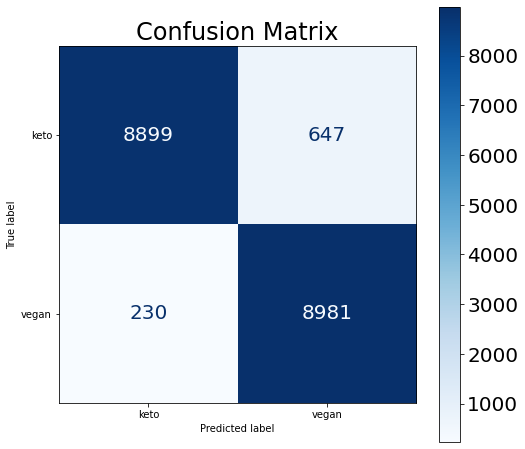

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(final_model, X, y, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.savefig('../images/Confusion_Matrix.png')
plt.show()


*Interpretation: Higher prediction for vegan text, but is actually keto text (false positive) compared to prediction for keto text but is actually vegan text(false negative). This higher false positive may indicate that vegan diet has coincide keto diet.*

In [47]:
print("Sensitivity: ", round(tp / (tp + fn),2))
print("Specificity: ", round(tn / (tn + fp),2))
print("Precision:", round(tp/(fp+tp),2))

Sensitivity:  0.98
Specificity:  0.93
Precision: 0.93


In [48]:
print("Accuracy: ", round((tn + tp) / (tn + fp + tp + fn),2))
print("Misclassification: ", round((1-(tn + tp) / (tn + fp + tp + fn)),2))

Accuracy:  0.95
Misclassification:  0.05


The model has a high sensitivity and specificity indicating a balance model in the classification with minimum error on both false positive and false negative. The overall high accuracy at 94% is demonstrating a good model for classification of vegan vs keto. However, we will still investigate on the misclassification as our focus since we would like to look for the overlaps or keywords that has misled the model to classify otherwise.

### Misclassification

The misclassification is reviewed to make inference on the reason behind the misclassification by the model.

#### False Positive

In [61]:
#create col for predicton analysis
pred_df['success'] = np.where(pred_df['preds_values'] == pred_df['true_values'],1,0)

#missclassification on fp and fn
miss_vegan = pred_df[(pred_df.success == 0) & (pred_df.preds_values == 'vegan')]
miss_keto = pred_df[(pred_df.success == 0)  & (pred_df.preds_values == 'keto')]

#sampling a few false positive text where classification predicted as vegan but it is a keto text

print('\033[1mFalse Positive Sample Text\033[0;0m')
print(pd.DataFrame(combined.loc[miss_vegan.index])['text'].sample(3).values)

False Positive Sample Text
["Origin Story Hey, guys. New to reddit and all that jazz, so I'm tryin to build up some karma to contribute to the conversation. If you could throw me some tips or topics to delve into, I'm considering looking into [r/oilpen](https://www.reddit.com/r/oilpen/) for some new smoking options."
 '50% off Trial: Lake Avenue Nutrition Bee propolis at iHerb'
 'A local taco place has hard taco shells made of cheese crisps!']


#### False Negative

In [57]:
#sampling a few false negative text where classification predicted as keto but it is a vegan text

print('\n\033[1mFalse Negative Sample Text\033[0;0m')
print(pd.DataFrame(combined.loc[miss_keto.index])['text'].sample(3).values)


False Negative Sample Text
['The only difference is still your perception.'
 "How do I get enough nutrients when only eating 1200-1400 calories a day?I have been slightly overweight for probably 6-7 years and I started counting calories and realised I was eating like 1800-2500 calories a day (as a 5'7 woman). I'm currently living a sedentary lifestyle so have been eating 1400 calories max the past 2 weeks and have already lost 4-5lbs! \n\nAbout 8 months ago I was getting dizzy so I started taking a multi-vitamin and have been fine since then. I tried to stop taking the multi-vitamin once and the dizziness came back so that further confirmed that I was lacking something even when I was eating a lot of calories. However, since I've been eating 1400 calories I am still taking my multi-vitamin, but now my dizziness is back. It specifically happens whenever I stand up. \n\nI'm using myfitnesspal and I'm not sure if it's 100% accurate, but according to it I seem to not be getting enough of 

**False Positive and False Negative**
Based on the above sampling text, this verifies our first observation during EDA, where the if the topic revolves around food, and recipes. This will be further investigated as we review the top words of each classification.

### Word Importance

In [62]:
coef = best_lr_tvec.named_steps['lr'].coef_
feature_names = best_lr_tvec.named_steps['tvec'].get_feature_names()
word_importance = pd.Series(coef[0], feature_names).sort_values()

In [63]:
#keto
word_importance.head(20)

keto      -16.473526
carb       -7.838483
fat        -4.702584
start      -4.506717
weight     -4.384943
ketosi     -4.115523
lb         -3.866338
week       -3.371019
keton      -3.316135
sugar      -3.134490
pound      -3.057326
cheat      -2.857955
macro      -2.834098
fast       -2.802767
lose       -2.790723
diet       -2.711791
day        -2.707767
nsv        -2.666816
lost       -2.311189
ketogen    -2.245241
dtype: float64

In [64]:
#vegan
word_importance.tail(20)

yummi          1.542705
made           1.546167
go vegan       1.589102
dog            1.603975
ban            1.610531
base           1.686444
farm           1.690863
ethic          1.695819
dairi          1.717658
plant base     1.942066
seitan         1.989954
human          2.053792
pig            2.117318
milk           2.333390
cow            2.364828
tofu           2.837498
plant          3.056197
meat           3.968269
anim           5.845560
vegan         14.353060
dtype: float64

In coefficient with importance to **keto** is mainly itself (keto) and other relevant topics such as carb, weight, fat, nsv (Non Scale Victory), macro which are common terms relevant to keto diet journey. The reddit community have discussion on the new diet to try on with curiosity to find out more on how to succesfully complete the diet and lost weight fast.

Wheres for **vegan** subredditers,the keywords revolves around animal products, vegan diets, and discussion on the ethics of animal products consumption.

## Crossover Review and Evaluation

In light of promoting vegan food products, we observed several commonalities in ingredients that can be tailored to keto dieters. To accomodate both diets, in essense it has to be animal-free, high fat, low carbohydrate, low sugar foods. 

This includes but not limited to the following: 

1. Seitan
2. Tofu
3. Curry
4. Mushroom
5. Tempe
6. Soy
7. Coffee
8. Avocado

No-Go Food for Keto:
1. Oat
2. Bread
3. Chickpea
4. Root based vegetables 
5. Dairy 
6. High sugar content food or drinks

In [65]:
#checking overlap of ingredient list
mask = combined.text.str.lower().str.contains('tofu') & (combined.subreddit=='keto')
combined[mask].text.sample(3).values

array(['Substitute for cornstarch in tofu recipes?',
       "Emergency grocery shopHey friends!\n\nI'm at my parents in the cornbelt for 2 weeks and struggle with a binge eating disorder. However, while in my own home I can control my surroundings with what I buy and bring into my home.\n\nMy parents on the other hand are obese couch potatos and have just accepted their fate. The cabinets have the whole snack aisle, and all the convenience of frozen or canned meals and soups. Not a vegetable in sight. Some rotten fruit in a bowl I assume were decoration.\n\nI want to be smart about the 2 weeks and not wasteful. I'm also fighting the urge to binge every moment around here. Just trying to stay out of the kitchen if I'm being honest.\n\nCan y'all do me a favor and drop a quick list you would turn to in a similar situation away from home. Keto only. I can't even think straight and worry I'll walk out of the shops with 8 lbs of celery and a single slab of steak. \n\nWith that said - I also 

In detail review on some of the text where top ingredient list (from the top word importance) that may overlap in keto-reddit above, we see the possibility that the ingredients from vegan diet can also be tailored to keto consumers. 

Vegan products that we could target are as shown on the list above. Nonetheless, the ingredient top keywords still require filtering and strong domain knowledge of keto diet preferences. The current model is not entirely ready-for-use for this problem statement.

## Conclusion & Recommendation

During the EDA, we found upward trend on popularity in keto subscribers which aligns with the increasing text query for help and advise. Most text are lengthy mainly due to explanation of their situation and seeking for recipes and information on how to decide what is within their diet constrain. Vegan and keto diets share several common grounds on the ingredients that is fit to be consumed. Examples are tofu, mushrooms, and tempe. This list will be insights to the R&D and marketing team on what is sought for from both dietary.

Using NLTK, TfidfVectoriser and logistic regression model, we are able to identify the top important words in the conversation among the community and dive deep into the list of ingredients that is being discussed. This shines light to what is the common acceptable ingredients used and the rest would be up to the marketing team to identify its feasiblity of production.

Despite the success in classification, this model still requires manual nitpick to identify food/ingredients related text prior to deployment. It would be a great addition to have NLP API that identifies food terminology, for instance `food` sysnet via WordNet (see code block below). Unfortunately, this list is not extensive and does not represent the ALL possible food list. 

    from nltk.corpus import wordnet as wn
    food = wn.synset('food.n.02')
    list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
    
[(code source link)](https://stackoverflow.com/questions/19626737/where-can-i-find-a-text-list-or-library-that-contains-a-list-of-common-foods)

With the overall model performance succesfully classifying with 95% accuracy and only 5% misclassification, this model can be translated and modified for use on other dietary groups as well. It is also shown that the misclassification is justified as there were sample text where the keywords of opposing categories has caused the false positive and false negative. Nonetheless, this does not affect our findings as our goal is to identify the ingredients list.

In the exploratory data analysis, we also find that dieters struggle with overwhelming information on what can or cannot be consumed. As solution provider, we want to make it fool-proof and easy for consumers to make decision. Knowing the keywords that dieters terminology, would make it easy for naming and packaging of products as well, killing two birds with one stone*. 

*No animals were harmed in the making of this pun.